In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gensim
import gensim .corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, Phrases
from gensim.models.ldamodel import LdaModel
from gensim.models.phrases import Phraser

import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_lg


import itertools, operator
import os
import pickle
from collections import defaultdict

from pprint import pprint
from tqdm import tqdm_notebook as tqdm

In [76]:
debates = pd.read_csv('debate_transcripts.csv')

candidates = ['Warren',
       'Klobuchar', "O'rourke", "O'Rourke", 'Booker', 'Castro', 'Gabbard', 'Patrick',
       'De Blasio', 'Delaney', 'Inslee', 'Ryan','Sanders', 'Bennet', 'Biden', 'Harris', 'Hickenlooper',
       'Gillibrand', 'Buttigieg', 'Yang', 'Swalwell', 'Williamson',
       'Bullock', 'Steyer', 'Bloomberg' ]

withdrawn = ['De Blasio', 'Bullock','Gillibrand','Gravel','Harris', 'Castro','Patrick','Delaney',
             'Hickenlooper','Inslee','Messam','Moulton','Ojeda',"O'rourke","O'Rourke",
             'Sestak','Swalwell','Ryan','Williamson','Gabbard','Bennet','Delaney','Castro','Booker'
            'Bennet','Yang']

debates['candidate'] = debates.apply(lambda x: 1 if x['speakers'] in candidates else 0, axis=1)
debates['withdrawn'] = debates.apply(lambda x: 1 if x['speakers'] in withdrawn else 0, axis=1)

stop_words = {'people','president','senator','thank','going','would','want',
              'right','one','think','american','america','sure',' ','country',
              'govenor','need','congressman','crosstalk','judy','oh','mention',
              'vain','name','sorry','mention','respond','come','say','respond','thing',
             'know','talk','get','look','fact','saying','inaudible','book','glad','decade',
             'fight','mean','way','like','time','states','year'}



In [77]:
nlp = spacy.load("en_core_web_lg")

nlp.Defaults.stop_words.update(stop_words)

for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop=True

def lemmatize_pipe(doc):
    
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    
    return nlp.make_doc(doc)

def remove_stops(doc):
    
    doc = [token.text for token in doc if nlp.vocab[token.text.lower()].is_stop!= True and token.is_punct != True and token.lemma_ not in STOP_WORDS]
    doc = u' '.join(doc)
    
    return nlp.make_doc(doc)

def list_component(doc):
    
    tokens = [token.text for token in doc]
          
    return tokens


def compute_coherence(dictionary, corpus, texts, limit, start=2, step=1):
    
    coherence_values=[]
    model_list=[]
    for num_topic in tqdm(range(start, limit, step)):
        model = LdaModel(corpus=corpus, num_topics=num_topic, id2word=dictionary)
        model_list.append(model)
        coherencemodel=CoherenceModel(model=model, texts=[texts], dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values

def compute_coherence_values(corpus, dictionary, texts, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k,
                                           alpha=a,
                                          chunksize=50,
                                          passes=10,
                                          random_state=5,
                                          eta=b,
                                          per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=[texts], dictionary=dictionary, coherence='c_v')
    
    return lda_model, coherence_model_lda.get_coherence()

def label_point_orig(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.2, point['y']+.1, str(point['val']))

In [78]:
nlp.add_pipe(remove_stops, before='ner')
nlp.add_pipe(lemmatize_pipe, last=True)
nlp.add_pipe(list_component, last=True)

In [79]:
candidates = debates[debates.candidate==1].speakers.unique()
cols = debates.columns
tmp_df = pd.DataFrame()

for candidate in candidates:
    tmp = debates[debates.speakers==candidate]
    arr = np.arange(len(tmp))
    arr = arr + 1
    tmp['n'] = arr
    tmp_df = tmp_df.append(tmp)

debates = pd.merge(debates, tmp_df[['n']], how='left',left_index=True, right_index=True )

C:\Users\Bryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [80]:
trim_responses = debates[debates.candidate==1].dialogue.tolist()
idxs = debates[debates.candidate==1].index.tolist()

idxs = [idx for idx, x in zip(idxs, trim_responses) if len(x.split()) > 11]

speakers = debates.iloc[idxs].speakers.tolist()

indexed_df = debates.iloc[idxs][['speakers','debate','n']]
indexed_df['key'] = indexed_df.speakers + ' ' + indexed_df.debate +' '+ indexed_df.n.astype(int).astype(str)
key = indexed_df.key.tolist()

trim_responses = [x for x in trim_responses if len(x.split()) > 11]
responses = list(nlp.pipe(trim_responses, disable=['tagger','parser','ner']))

In [7]:
bigram = Phrases(responses, min_count = 3)
trigram = Phrases(bigram[responses], min_count=2)
qgram = Phrases(trigram[responses], min_count=2)
fgram = Phrases(qgram[responses],min_count=2)
sgram = Phrases(fgram[responses])

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)
qgram_mod = Phraser(qgram)
fgram_mod = Phraser(fgram)
sgram_mod = Phraser(sgram)

def create_n_grams(text):
    return sgram[fgram_mod[qgram_mod[trigram_mod[bigram_mod[text]]]]]

In [8]:
all_tokens = [create_n_grams(doc) for doc in responses]

all_responses = corpora.Dictionary(all_tokens)
corpus = [all_responses.doc2bow(doc) for doc in all_tokens]
texts = list(itertools.chain.from_iterable(all_tokens))

In [9]:
'''model_list, coherence_values = compute_coherence(dictionary=all_responses,
                                                 corpus=corpus,
                                                 texts=texts,
                                                 start=1,
                                                 limit=18,
                                                 step=1  )'''

'model_list, coherence_values = compute_coherence(dictionary=all_responses,\n                                                 corpus=corpus,\n                                                 texts=texts,\n                                                 start=1,\n                                                 limit=18,\n                                                 step=1  )'

In [10]:
'''with open('naiave_model_list_cv.pkl', 'wb') as f:
    pickle.dump(model_list, f)
    
with open('coherence_values.pkl', 'wb') as f:
    pickle.dump(coherence_values, f)'''

"with open('naiave_model_list_cv.pkl', 'wb') as f:\n    pickle.dump(model_list, f)\n    \nwith open('coherence_values.pkl', 'wb') as f:\n    pickle.dump(coherence_values, f)"

In [11]:
model_list = pickle.load( open( 'naiave_model_list_cv.pkl', 'rb' ) )
coherence_values = pickle.load(open('coherence_values.pkl','rb'))

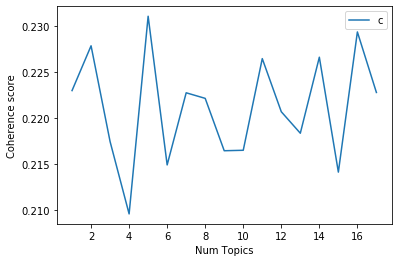

In [12]:
limit=18; start=1
x=range(start, limit)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend('coherence_values', loc='best')
plt.show()

In [13]:
pprint(coherence_values)
index, value = max(enumerate(coherence_values), key=operator.itemgetter(1))
num_topics = len(coherence_values[:index+1])
print(index, value)

[0.22295741197514954,
 0.2278310938934216,
 0.21740801952631336,
 0.2095393203367028,
 0.2310465621342404,
 0.21487064876117204,
 0.22271794265415235,
 0.22211120292795977,
 0.21641351464007758,
 0.21646363768565688,
 0.2264359201870123,
 0.22065585901859408,
 0.21831925055016393,
 0.22658963732087875,
 0.21408707000217056,
 0.22933933227944792,
 0.22275238216481794]
4 0.2310465621342404


In [14]:
'''topic_range = [5]

    
alpha = list(np.arange(0.01, 1, 0.3)) + [50/x  for x in topic_range]
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
    
num_of_docs = len(corpus)
corpus_sets = [corpus]
    
corpus_title = ['100% Corpus']
    
model_results = {'Validation_set': [],
                    'Topics':[],
                    'Alpha':[],
                 'Beta':[],
                    'Coherence':[]}
models=[]
    
if 1 ==1:
    pbar = tqdm(total=len(topic_range) * len(alpha) * len(beta) * len(corpus_sets))
    
    for i in range(len(corpus_sets)):
        for k in topic_range:
            for a in alpha:
                for b in beta:
                    
                    model, cv = compute_coherence_values(corpus=corpus_sets[i],
                                                  dictionary=all_responses,
                                                     texts=texts,
                                                  k=k,
                                                  a=a,
                                                        b=b)
                    model_results['Validation_set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    models.append(model)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()
    
    '''

"topic_range = [5]\n\n    \nalpha = list(np.arange(0.01, 1, 0.3)) + [50/x  for x in topic_range]\nalpha.append('symmetric')\nalpha.append('asymmetric')\n\n# Beta parameter\nbeta = list(np.arange(0.01, 1, 0.3))\nbeta.append('symmetric')\n    \nnum_of_docs = len(corpus)\ncorpus_sets = [corpus]\n    \ncorpus_title = ['100% Corpus']\n    \nmodel_results = {'Validation_set': [],\n                    'Topics':[],\n                    'Alpha':[],\n                 'Beta':[],\n                    'Coherence':[]}\nmodels=[]\n    \nif 1 ==1:\n    pbar = tqdm(total=len(topic_range) * len(alpha) * len(beta) * len(corpus_sets))\n    \n    for i in range(len(corpus_sets)):\n        for k in topic_range:\n            for a in alpha:\n                for b in beta:\n                    \n                    model, cv = compute_coherence_values(corpus=corpus_sets[i],\n                                                  dictionary=all_responses,\n                                                     texts=

In [15]:
models = pickle.load( open( 'models_final.pkl', 'rb' ) )
model_results = pickle.load(open('model_results_final.pkl','rb'))

In [16]:
lda_tuning = pd.DataFrame(model_results)
lda_tuning.head()

,Validation_set,Topics,Alpha,Beta,Coherence
0,100% Corpus,5,0.01,0.01,0.258793
1,100% Corpus,5,0.01,0.31,0.272043
2,100% Corpus,5,0.01,0.61,0.322858
3,100% Corpus,5,0.01,0.91,0.364481
4,100% Corpus,5,0.01,symmetric,0.286757


In [17]:
idx =lda_tuning['Coherence'].idxmax(axis=0)
lda_tuning.iloc[idx]

Validation_set    100% Corpus
Topics                      5
Alpha                    0.91
Beta                     0.91
Coherence            0.437322
Name: 18, dtype: object

In [18]:
pprint(models[idx].print_topics(num_words=15))

[(0,
  '0.013*"plan" + 0.010*"Medicare" + 0.009*"pay" + 0.008*"health_care" + '
  '0.006*"like" + 0.006*"cost" + 0.004*"year" + 0.004*"family" + 0.004*"cover" '
  '+ 0.003*"way" + 0.003*"healthcare" + 0.003*"buy" + 0.003*"insurance" + '
  '0.003*"afford" + 0.003*"system"'),
 (1,
  '0.011*"work" + 0.008*"way" + 0.007*"time" + 0.006*"like" + '
  '0.005*"United_States" + 0.005*"believe" + 0.005*"issue" + '
  '0.004*"Donald_Trump" + 0.004*"bring" + 0.004*"run" + 0.004*"live" + '
  '0.004*"job" + 0.004*"tell" + 0.004*"year" + 0.004*"stage"'),
 (2,
  '0.007*"woman" + 0.004*"law" + 0.004*"justice" + 0.004*"judge" + 0.003*"man" '
  '+ 0.003*"respect" + 0.002*"reform" + 0.002*"understand" + 0.002*"expect" + '
  '0.002*"body" + 0.002*"let" + 0.002*"believe" + 0.002*"weapon" + '
  '0.002*"kill" + 0.002*"gun"'),
 (3,
  '0.002*"transform" + 0.002*"45_year" + 0.001*"pick_United_States" + '
  '0.001*"real_change_place" + 0.001*"fundraiser" + 0.001*"nickel" + '
  '0.001*"wine_cave" + 0.001*"truth" + 0

In [19]:

vis = pyLDAvis.gensim.prepare(models[idx], corpus, all_responses)
vis

ValidationError: 
 * Not all rows (distributions) in topic_term_dists sum to 1.

In [ ]:

"""with open('model_results_final.pkl', 'wb') as f:
    pickle.dump(model_results, f)
    
with open('models_final.pkl', 'wb') as f:
    pickle.dump(models, f)"""

In [20]:
#models = pickle.load( open( 'models_final.pkl', 'rb' ) )
#model_results = pickle.load(open('model_results_final.pkl','rb'))

In [21]:

response_topic = {}


for response in range(len(corpus)): # for each response/document in corpus
    re_bow = corpus[response]        #obtain the bow for the response
    res_topics = models[idx].get_document_topics(re_bow, 0) #obtain the topics mentioned in the response
    tmp = []
    for topic_id, topic_prob in res_topics: #obtain the topic id and topic probability for each topic in the response
        tmp.append(topic_prob)
    response_topic[key[response]]=tmp #assign the topic

In [22]:
topics_df = pd.DataFrame.from_dict(response_topic, orient='index')

candidates_response = [x.split(' ')[0] if x.split(' ')[1][0] in ['F','S','T'] else ' '.join(x.split(' ')[:2]) for x in topics_df.index]

In [23]:
topics_response = topics_df
topics_response['candidate'] = pd.Series(candidates_response, index=topics_df.index)
topic_col_names = ['topic_'+str(i) for i in range(5)]
topic_col_names.append('candidate')
topics_response.columns = topic_col_names

In [24]:
topics_response.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,candidate
Warren First Debate 2,0.043984,0.852260,0.033116,0.035084,0.035557,Warren
Klobuchar First Debate 1,0.278196,0.649451,0.022061,0.023418,0.026874,Klobuchar
O'Rourke First Debate 1,0.173331,0.288182,0.173468,0.190828,0.174192,O'Rourke
O'Rourke First Debate 2,0.114987,0.638420,0.050702,0.046557,0.149334,O'Rourke
O'Rourke First Debate 3,0.172312,0.412512,0.128879,0.150137,0.136159,O'Rourke


# Clustering responses & candidates

## Visualizing individual responses by topic

In [25]:
from sklearn.manifold import TSNE
import colorsys

In [26]:
tsne = TSNE(n_components=2,
            init='pca', 
            random_state=5, 
            perplexity = 50,
            n_iter=5000,
            learning_rate=10).fit_transform(topics_response[['topic_'+str(i) for i in range(5)]])

candidate_clusters = pd.DataFrame(tsne)
candidate_clusters = candidate_clusters.set_index(topics_response.index)

In [28]:
#can this be moved up one spot?
candidate_clusters['candidate']=[x.split(' ')[0] if x.split(' ')[1][0] in ['F','S','T'] else ' '.join(x.split(' ')[:2]) for x in candidate_clusters.index]


In [27]:
candidates = topics_response.candidate.tolist()
unique_candidates = list(set(candidates))
N = len(unique_candidates)
HSV_tups = [(x*1.0/N, .9, .9) for x in range(N)]
RGB_tups = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tups)

cand_colors = {}
for c, i in zip(unique_candidates, RGB_tups):
    cand_colors[c] = i

In [29]:
#adjust and save the csv
topics_response['response_n']=list(range(1,len(corpus)+1))
topics_response.reset_index(drop=True,inplace=True )
topics_response.to_csv('topics_by_response.csv',index=False)

In [97]:
debate_locs = debates.iloc[idxs][['date','debate']]
debate_locs['location'] = debates.apply(lambda x: x['debate'] +' '+ x['date'],axis=1)
debate_id = debate_locs.location.tolist()

candidate_clusters['debate_id'] = debate_id

In [127]:
unique_debates = list(set(debate_id))
N_d = len(unique_debates)

HSV_tups = [(x*1.0/N_d, .9, .9) for x in range(N)]
RGB_tups = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tups)

debate_colors = {}
for c, i in zip(unique_debates, RGB_tups):
    debate_colors[c] = i

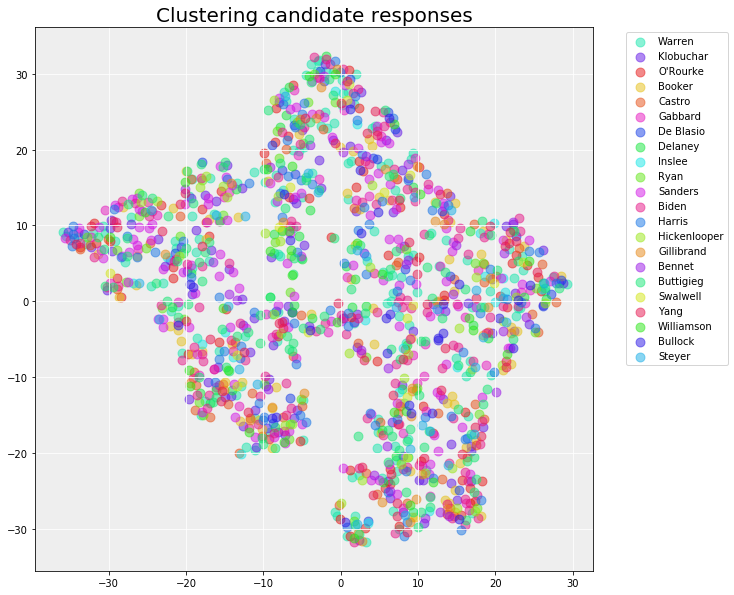

In [30]:
fig, ax = plt.subplots(subplot_kw=dict(facecolor='#EEEEEE'), figsize=(10,10))
ax.grid(color='white', linestyle='solid')

for c in candidate_clusters.candidate.unique():
    scatter = ax.scatter(candidate_clusters[candidate_clusters.candidate==c].loc[:,0].tolist(),
                    candidate_clusters[candidate_clusters.candidate==c].loc[:,1].tolist(),
                    s=80,
                    label=c,
                    alpha=.5,
                    c=np.array(cand_colors[c]).reshape(1,3))

ax.grid(color='white', linestyle='solid')
ax.set_title('Clustering candidate responses', size=20)
#labels=['<h3>{candidate}</h3>'.format(candidate=x) for x in candidates]
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()   

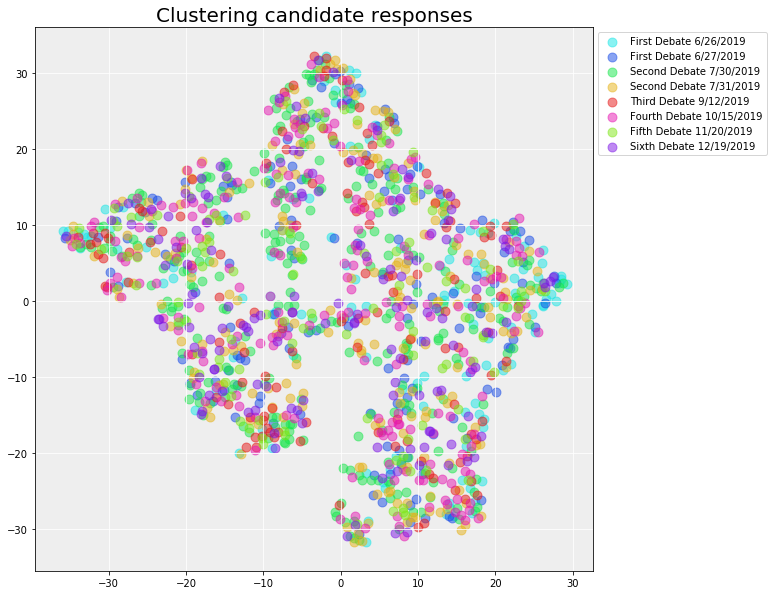

In [128]:
fig, ax = plt.subplots(subplot_kw=dict(facecolor='#EEEEEE'), figsize=(10,10))
ax.grid(color='white', linestyle='solid')

for d in candidate_clusters.debate_id.unique():
    scatter = ax.scatter(candidate_clusters[candidate_clusters.debate_id==d].iloc[:,0].tolist(),
                    candidate_clusters[candidate_clusters.debate_id==d].iloc[:,1].tolist(),
                    s=80,
                    label=d,
                    alpha=.5,
                    c=np.array(debate_colors[d]).reshape(1,3))

ax.grid(color='white', linestyle='solid')
ax.set_title('Clustering candidate responses', size=20)
#labels=['<h3>{candidate}</h3>'.format(candidate=x) for x in candidates]
plt.legend(bbox_to_anchor=(1.32, 1))
plt.show() 

In [31]:
candidate_clusters.reset_index(inplace=True)
candidate_clusters['debate'] = candidate_clusters.apply(lambda x: str(x['index']).split(' ')[1], axis=1)

In [32]:
candidate_clusters.drop(columns=['index'], inplace=True)

In [33]:
candidate_clusters.columns=['x','y','candidate','debate','debate_id']

In [129]:
candidate_clusters.to_csv('tsne_cluster_by_response.csv', index=False)
display(candidate_clusters.head())

,x,y,candidate,debate,debate_id
0,29.227682,2.228123,Warren,First,First Debate 6/26/2019
1,26.149435,6.763986,Klobuchar,First,First Debate 6/26/2019
2,1.279037,-2.022129,O'Rourke,First,First Debate 6/26/2019
3,25.559345,3.133706,O'Rourke,First,First Debate 6/26/2019
4,13.287237,0.847854,O'Rourke,First,First Debate 6/26/2019


## Visualizing candidates by the topics in their responses

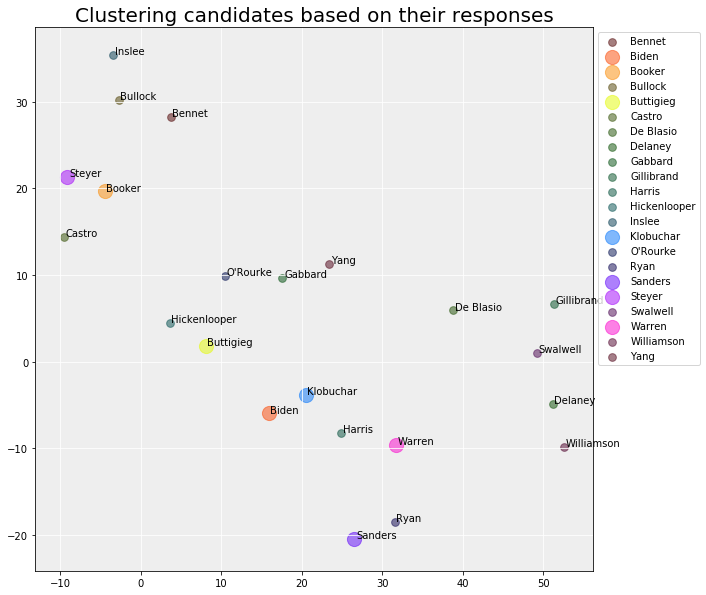

In [35]:
columns = ['topic_'+str(i) for i in range(5)]
df = topics_response.groupby('candidate')[columns].sum()
df = 100*df.div(df.sum(axis=1), axis=0)
df=np.round(df,1)

s_cluster_t = TSNE(n_components=2,
                   init='pca', 
                   random_state=5, 
                   perplexity = 5,
                   n_iter=5000,
                   early_exaggeration=1,
                   learning_rate=10.0).fit_transform(df)

s_cluster = pd.DataFrame(s_cluster_t)
s_cluster = s_cluster.set_index(df.index)

candidates_s = df.index.tolist()
N = len(candidates_s)
HSV_tups = [(x*1.0/N, .98, .98) for x in range(N)]
RGB_tups = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tups)

cand_colors_s = {}
for c, i in zip(candidates_s, RGB_tups):
    cand_colors_s[c] = i
    
sizes = {}
for i in cand_colors_s.keys():
    if i.split(' ')[0].lower() in [x.split(' ')[0].lower() for x in withdrawn]:
        sizes[i] = 60
    else:
        sizes[i] = 200

for i in cand_colors_s.keys():
    if i.split(' ')[0].lower() in [x.split(' ')[0].lower() for x in withdrawn]:
        cand_colors_s[i] = tuple(map(lambda x: x/3.2, cand_colors_s[i]))

fig, ax = plt.subplots(subplot_kw=dict(facecolor='#EEEEEE'), figsize=(10,10))
ax.grid(color='white', linestyle='solid')

for c in candidates_s:
    scatter = ax.scatter(s_cluster.loc[c][0],
                    s_cluster.loc[c][1],
                    s=sizes[c],
                    label=c,
                    alpha=.5,
                    c=np.array(cand_colors_s[c]).reshape(1,3))
    label_point_orig(pd.Series(s_cluster.loc[c][0]),
                     pd.Series(s_cluster.loc[c][1]),
                     pd.Series(c),
                     ax)

ax.grid(color='white', linestyle='solid')
ax.set_title('Clustering candidates based on their responses', size=20)
plt.legend(bbox_to_anchor=(1, 1))
plt.show() 

In [36]:
s_cluster.reset_index(inplace=True)
s_cluster.columns=['candidate','x','y']

In [37]:
'''cluster candidates by an aggregate of all their response topics'''
s_cluster.to_csv('tsne_cluster_by_candidate_rs.csv', index=False)
display(s_cluster.head())

,candidate,x,y
0,Bennet,3.729920,28.224819
1,Biden,15.881277,-5.976402
2,Booker,-4.470454,19.642681
3,Bullock,-2.692041,30.216827
4,Buttigieg,8.106873,1.820878


# Visualizing candidates by the words in their responses

In [38]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile

In [39]:
def tsne_plot(model, p=5, lr=10.0, ee=1):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for doc in model.docvecs.index2entity:
        tokens.append(model[doc])
        labels.append(doc)
    
    tsne_model = TSNE(perplexity=p,
                      n_components=2,
                      init='pca',
                      n_iter=5000,
                      learning_rate=lr,
                      random_state=5,
                     early_exaggeration=ee)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i], s=80)
        plt.annotate(labels[i],
                     xy=(x[i]-.1, y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    
def tsne_plot_dict(data , p=5, lr=10.0, ee=1):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for doc, arr in data.items():
        tokens.append(arr)
        labels.append(doc)
    
    tsne_model = TSNE(perplexity=p,
                      n_components=2,
                      init='pca',
                      n_iter=5000,
                      learning_rate=lr,
                      random_state=5,
                     early_exaggeration=ee)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i], s=100)
        plt.annotate(labels[i],
                     xy=(x[i]-.15, y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    
    new_values = pd.DataFrame(new_values, columns = ['x','y'])
    new_values.index=labels
    
    return new_values

In [40]:
'''words_by_candidate = defaultdict(list)
for speaker, response in zip(speakers, all_tokens):
    words_by_candidate[speaker].append(response)
    
#ls_of_words = [word for candidate, wordlist in words_by_candidate.items() for word in wordlist]
#words_by_candidate = dict(zip(list(words_by_candidate.keys()),ls_of_words))


#documents = [TaggedDocument(doc, [tag]) for tag, doc in words_by_candidate.items()]

for candidate, sents in words_by_candidate.items():
    words_by_candidate[candidate] = [word for sent in sents for word in sent]
documents = [TaggedDocument(doc, [tag]) for tag, doc in words_by_candidate.items()]'''

'words_by_candidate = defaultdict(list)\nfor speaker, response in zip(speakers, all_tokens):\n    words_by_candidate[speaker].append(response)\n    \n#ls_of_words = [word for candidate, wordlist in words_by_candidate.items() for word in wordlist]\n#words_by_candidate = dict(zip(list(words_by_candidate.keys()),ls_of_words))\n\n\n#documents = [TaggedDocument(doc, [tag]) for tag, doc in words_by_candidate.items()]\n\nfor candidate, sents in words_by_candidate.items():\n    words_by_candidate[candidate] = [word for sent in sents for word in sent]\ndocuments = [TaggedDocument(doc, [tag]) for tag, doc in words_by_candidate.items()]'

In [41]:
documents = [TaggedDocument(doc, [tag]) for tag, doc in zip(speakers, trim_responses)]

dm_model=Doc2Vec(documents, dm=1, alpha=.025, vector_size=100, min_alpha=.025, min_count=0, seed=5, sorted_vocab=True)
dbow_model=Doc2Vec(documents, dm=0, alpha=.025, vector_size=100, min_alpha=.025, min_count=0, seed=5, sorted_vocab=True)


for epoch in tqdm(range(20)):
    dm_model.train(documents, total_examples=dm_model.corpus_count, epochs =20)
    dm_model.alpha-=.002
    dm_model.min_alpha = dm_model.alpha

for epoch in tqdm(range(20)):
    dbow_model.train(documents, total_examples=dbow_model.corpus_count, epochs =20)
    dbow_model.alpha-=.002
    dbow_model.min_alpha = dbow_model.alpha
    
    


C:\Users\Bryan\Anaconda3\lib\site-packages\tqdm\__init__.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  TqdmDeprecationWarning)


C:\Users\Bryan\Anaconda3\lib\site-packages\tqdm\__init__.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  TqdmDeprecationWarning)


In [42]:
fname = get_tmpfile('doc2vec_dm_model')
dm_model.save(fname)
dm_model=Doc2Vec.load(fname)

fname = get_tmpfile('doc2vec_dbow_model')
dbow_model.save(fname)
dbow_model=Doc2Vec.load(fname)

In [43]:
similarity_df = defaultdict(list)
for model in [dm_model, dbow_model]:
    n_cands = len(model.docvecs.index2entity)
    for candidate in model.docvecs.index2entity:
        for (o_candidate, sim) in model.docvecs.most_similar(candidate, topn=n_cands):
            similarity_df['candidate'].append(candidate)
            similarity_df['opp_candidate'].append(o_candidate)
            similarity_df['similarity'].append(sim)
            similarity_df['model'].append(str(model)[8:12])
        
similarity_df = pd.DataFrame(similarity_df)   

In [44]:
similarity_df.to_csv('candidate_word_r_similarity.csv', index=False)
display(similarity_df.head())

,candidate,opp_candidate,similarity,model
0,Warren,Buttigieg,0.581764,dm/m
1,Warren,Williamson,0.500155,dm/m
2,Warren,Klobuchar,0.493997,dm/m
3,Warren,Hickenlooper,0.467486,dm/m
4,Warren,Delaney,0.466514,dm/m


In [45]:
concat_arry={}

for candidate in dbow_model.docvecs.index2entity:
    concat_arry[candidate]=np.concatenate((dm_model[candidate], dbow_model[candidate]))

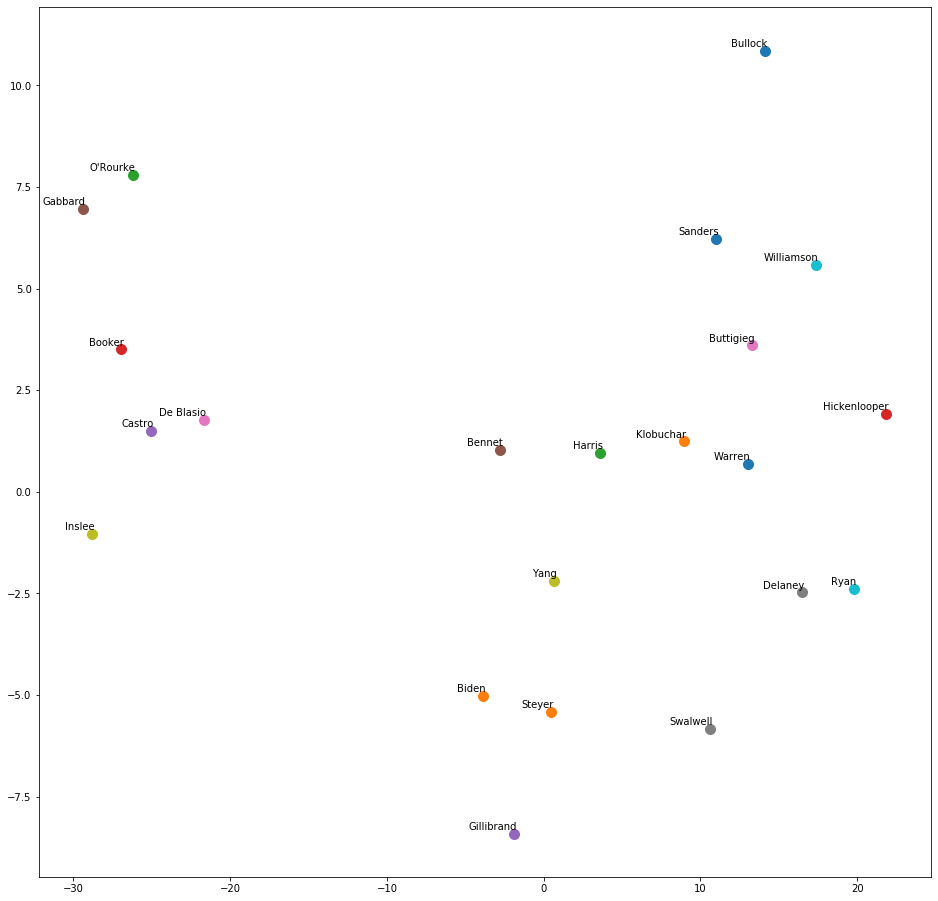

In [46]:
tsne_points_df = tsne_plot_dict(concat_arry) 

In [47]:
tsne_points_df.to_csv('tsne_vals_docvec.csv', index=False)
tsne_points_df.head()

,x,y
Warren,13.040030,0.691044
Klobuchar,8.952151,1.239278
O'Rourke,-26.196590,7.796889
Booker,-26.935938,3.502980
Castro,-25.057440,1.489357


# Debate topics by Response

In [48]:
def format_topics_sentences(lda_model, corpus=corpus, texts=texts, speakers=speakers):
    
    sent_topics_df = pd.DataFrame()
    
    for i, row in enumerate(lda_model[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ', '.join([word for word,prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['dominant_topic','perc_contribution','topic_keywords']
    
    contents = pd.Series(texts)
    speakers = pd.Series(speakers)
    sent_topics_df = pd.concat([sent_topics_df, contents, speakers],axis=1)
    return(sent_topics_df)



### Find the dominant topic in each sentence

In [49]:
df_topic_sents_keywords = format_topics_sentences(models[33], corpus, trim_responses, speakers)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns=['document_no','dominant_topic','topic_perc_contrib', 'keywords','text','candidate']


In [50]:
'''display the the dominant dopic & perc contribution for each response'''
df_dominant_topic.to_csv('dominant_topic_per_response.csv', index=False)
display(df_dominant_topic.head())

,document_no,dominant_topic,topic_perc_contrib,keywords,text,candidate
0,0,1.0,0.9780,"work, way, like, time, believe, United_States,...",So I think of it this way. Who is this economy...,Warren
1,1,1.0,0.7975,"work, way, like, time, believe, United_States,...","Well, first, the economy. We know that not eve...",Klobuchar
2,2,1.0,0.5974,"work, way, like, time, believe, United_States,...",This economy has got to work for everyone. And...,O'Rourke
3,3,1.0,0.9785,"work, way, like, time, believe, United_States,...","Right now, we have a system that favors those ...",O'Rourke
4,4,1.0,0.8362,"work, way, like, time, believe, United_States,...",That's how we each have a voice in our democra...,O'Rourke


## Find the most representative response for each topic

In [51]:
res_topics_sorted_btopic=pd.DataFrame()
topic_sents_grpd = df_topic_sents_keywords.groupby('dominant_topic')
for i, grp in topic_sents_grpd:
    res_topics_sorted_btopic=pd.concat([res_topics_sorted_btopic,grp.sort_values(['perc_contribution'],
                                                                                 ascending=[0]).head(5)],
                                       axis=0)

res_topics_sorted_btopic.reset_index(drop=True, inplace=True)
res_topics_sorted_btopic.columns=['topic_num','topic_perc_contrib','keywords','text','candidate']

In [52]:
'''Top 5 contributing responses per topic'''
res_topics_sorted_btopic.to_csv('top_topics_responses.csv', index=False)
display(res_topics_sorted_btopic.head())

,topic_num,topic_perc_contrib,keywords,text,candidate
0,0.0,0.9540,"Medicare, plan, health_care, pay, like, cost, ...",New and better is this. Move medicare down to ...,Ryan
1,0.0,0.9490,"Medicare, plan, health_care, pay, like, cost, ...","Look, this is a distinction without a differen...",Buttigieg
2,0.0,0.9369,"Medicare, plan, health_care, pay, like, cost, ...",... health insurance program in the country. P...,Sanders
3,0.0,0.9263,"Medicare, plan, health_care, pay, like, cost, ...",The basic model of an insurance company has ta...,Warren
4,0.0,0.9169,"Medicare, plan, health_care, pay, like, cost, ...","Yes. Look, around the world we will do whateve...",Buttigieg


## Find the 5 most representative responses for each topic

In [53]:
topic_text_df = defaultdict(list)

for topic in sorted(df_dominant_topic.dominant_topic.unique()):
    for candidate in df_dominant_topic.candidate.unique():
        for rating, text in enumerate(df_dominant_topic[(df_dominant_topic.dominant_topic==topic)&(df_dominant_topic.candidate==candidate)].sort_values('topic_perc_contrib', ascending=False).text[:6].tolist()):
            topic_text_df['candidate'].append(candidate)
            topic_text_df['topic'].append(topic)
            topic_text_df['text'].append(text)
            topic_text_df['rating'].append(rating+1)
topic_text_df = pd.DataFrame.from_dict(topic_text_df)

In [54]:
'''Top 5 contributing responses per topic by  candidate'''
topic_text_df.to_csv('top_topics_by_candidate.csv', index=False)
display(topic_text_df.head())

,candidate,topic,text,rating
0,Warren,0.0,The basic model of an insurance company has ta...,1
1,Warren,0.0,... when 54 senators voted in favor of gun le...,2
2,Warren,0.0,"We can't have people who can put down $5,000 ...",3
3,Warren,0.0,"His wife, Rachel is on the phone for hours and...",4
4,Warren,0.0,We have tried this experiment with the insuran...,5
